❕To run the notebook on Google Collab, uncomment and run the following cells.✅

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

# 0. Import libraries and dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import the Global Crises Data by Country dataset and the Maddison Project Database 2020.

In [4]:
data = pd.read_csv('../raw_data/global_crisis_data_country.csv', encoding='unicode_escape')
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')

Preprocess the two dataset with the functions from the preprocess_dataset.py python file. The functions are renaming, dropping and changing the data type of certain columns or rows for clarity purpose.

In [5]:
from preprocess_dataset import preprocess_global_crises_data
from preprocess_dataset import preprocess_mdp_data

preprocess_global_crises_data(data)
preprocess_mdp_data(GDP_pc)

# 1. Selecting a set of countries to analyse

The following lists contain country codes representing different groups of countries 🌍.  
The last list `ALL` is created by taking the intersection of unique country codes present in two datasets (`data` and `GDP_pc`). It contains the list of all unique country codes present in both datasets.

In [7]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
UE = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#List for all countries
unique_countries_df1 = set(data['CC3'].unique())
unique_countries_df2 = set(GDP_pc['Code'].unique())
ALL = list(unique_countries_df1.intersection(unique_countries_df2))

## Dataset Selection and Creation

This cell selects a list of countries from the predefined lists (`OECD`, `G7`, `G20`, `UE`, `USA`) and creates a dataset containing the data for those countries.

- `countries_selected`: This variable is assigned one of the predefined country lists (e.g., `G7`). You can choose any list among those defined above.
- The `concat_dataset` function is then called to create a dataset (`global_data`) by concatenating the data from two datasets (`data` and `GDP_pc`) for the selected countries.
- Finally, the `dummy_variable` function is applied to the `global_data` dataset to perform any necessary preprocessing or feature engineering.

The resulting `global_data` dataset contains the merged data for the selected countries, along with any additional preprocessing applied by the `dummy_variable` function.


In [31]:
from dataset import concat_dataset
from dataset import dummy_variable

#Select a list among those listed above:
countries_selected = G7

#Create a dataset with the data of the countries of the list
global_data = concat_dataset(data, GDP_pc, countries_selected, 'left')

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data)

# Display the resulting dataset (here the first 5 rows)
global_data.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,9.0,CAN,Canada,1800,0.0,NaN,0.0,0,0.2441,NaN,...,NaN,NaN,0,0,0.0,NaN,0,0,0,0
1,9.0,CAN,Canada,1801,0.0,NaN,0.0,0,0.2379,NaN,...,NaN,NaN,0,0,0.0,NaN,0,0,0,0
2,9.0,CAN,Canada,1802,0.0,NaN,0.0,0,0.2553,NaN,...,NaN,NaN,0,0,0.0,NaN,0,0,0,0
3,9.0,CAN,Canada,1803,0.0,NaN,0.0,0,0.2527,NaN,...,NaN,NaN,0,0,0.0,NaN,0,0,0,0
4,9.0,CAN,Canada,1804,0.0,NaN,0.0,0,0.243,NaN,...,NaN,NaN,0,0,0.0,NaN,0,0,0,0


In [9]:
banking_crisis_only_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 65 different crisis event.


In [10]:
from functionsA import compute_crisis_duration
from functionsA import length_frequency

In [11]:
crisis_duration = compute_crisis_duration(global_data)
frequency_table = length_frequency(crisis_duration)
frequency_table

,Length,Count,Number of points
0,1,33,65
1,2,13,32
2,3,8,19
3,4,4,11
4,5,1,7
5,6,1,6
6,7,2,5
7,8,2,3
8,10,1,1


# 2. Extracting inflation series

In [12]:
from functionsA import extract_inflation_series
from functionsA import normalize_crisis_data

In [13]:
inflation_series = extract_inflation_series(global_data)
norm_inflation_series = normalize_crisis_data(inflation_series)
len(inflation_series)

65

## 2.1 Inflation response to each year of crisis

In [14]:
from visualisation import plot_by_crisis_length
from visualisation import compute_pattern

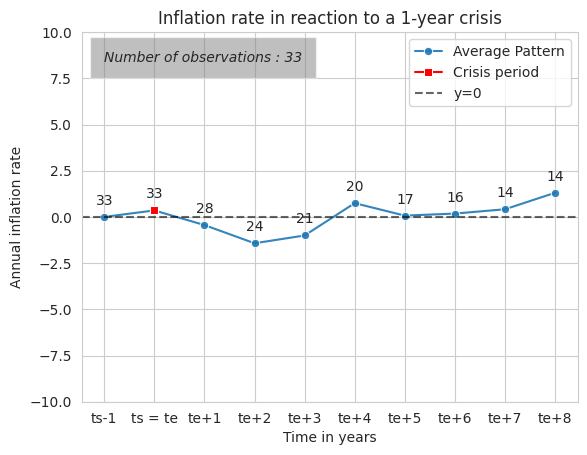

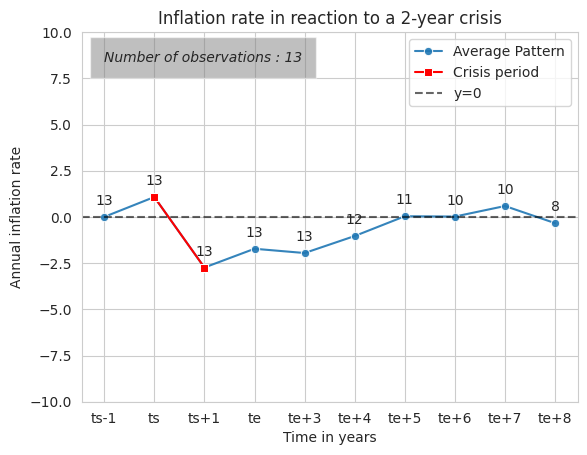

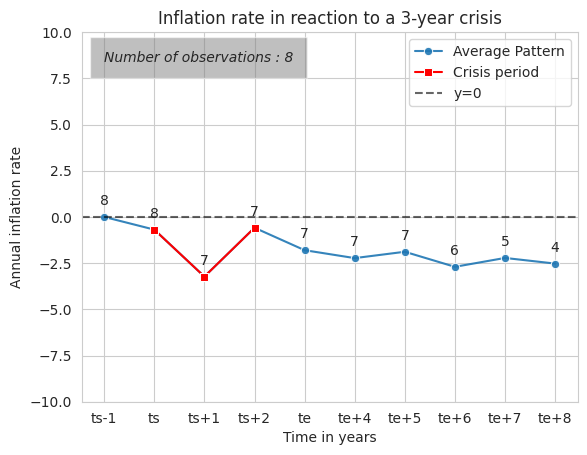

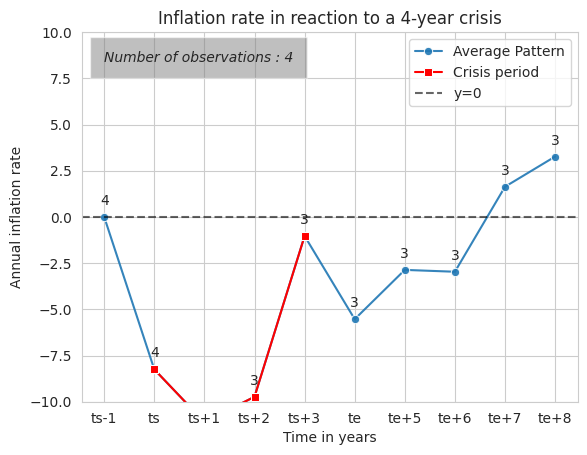

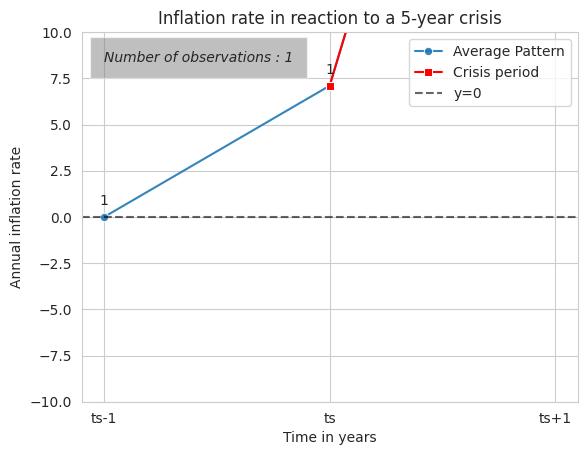

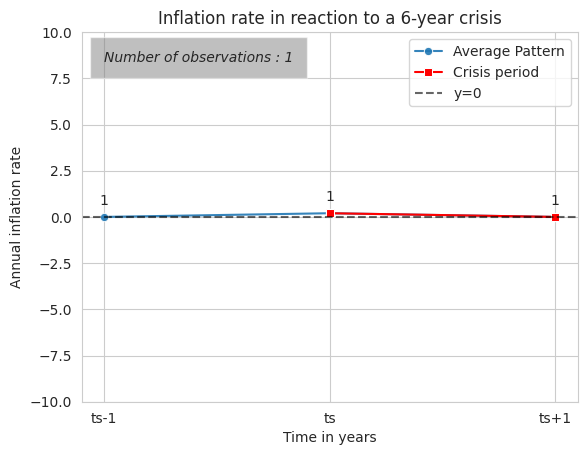

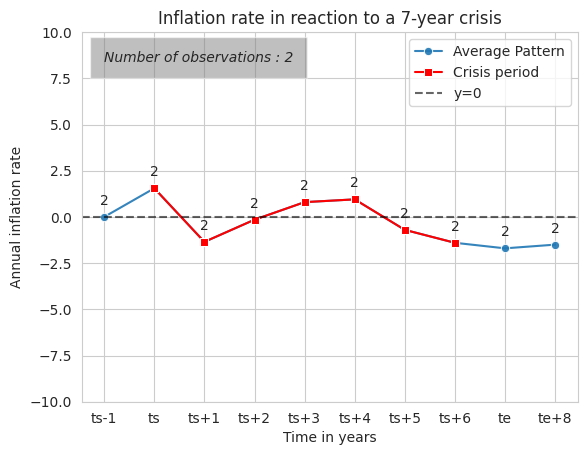

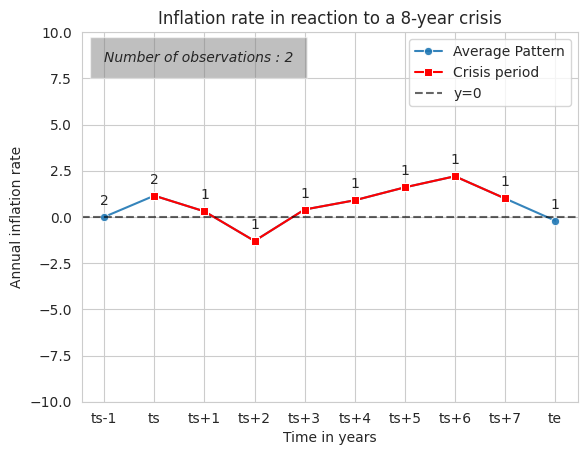

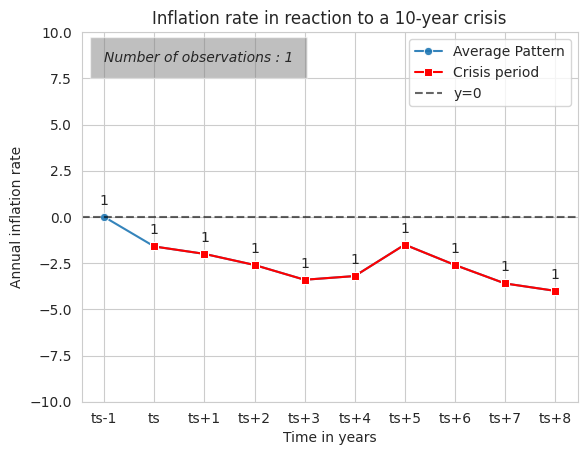

In [15]:
plot_by_crisis_length(norm_inflation_series, crisis_duration, frequency_table, 'Inflation rate')

# 3. Extracting output gap series

In [16]:
from functionsA import extract_output_gap_series

In [18]:
global_data_inner = concat_dataset(data, GDP_pc, countries_selected, 'inner')
dummy_variable(global_data_inner)
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,9.0,CAN,Canada,1820,0.0,NaN,0.0,0,0.2627,NaN,...,NaN,NaN,0,0,0.0,-18.21,0,0,0,0
1,9.0,CAN,Canada,1830,0.0,NaN,0.0,0,0.2465,NaN,...,NaN,NaN,0,0,0.0,-15.41,0,0,0,0
2,9.0,CAN,Canada,1840,0.0,NaN,0.0,0,0.2561,NaN,...,NaN,NaN,0,0,0.0,-7.68,0,0,0,0
3,9.0,CAN,Canada,1850,0.0,NaN,0.0,0,0.2566,NaN,...,NaN,NaN,0,0,0.0,-0.25,0,0,0,0
4,9.0,CAN,Canada,1860,0.0,NaN,0.0,1,0.9902,NaN,...,NaN,NaN,0,0,0.0,3.24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,2.1,1,0,0.0,-1.90,0,0,0,1
1304,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,1.5,1,0,0.0,-1.85,0,0,0,1
1305,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,1.6,1,0,0.0,-1.19,0,0,0,1
1306,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.1,1,0,NaN,-0.32,0,0,0,1


In [19]:
banking_crisis_only_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 61 different crisis event.


In [20]:
crisis_duration = compute_crisis_duration(global_data_inner)
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,32,61
1,2,12,29
2,3,8,17
3,4,3,9
4,6,1,6
5,7,2,5
6,8,2,3
7,10,1,1


In [21]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

61

## 3.1 Output gap response for each length of crisis

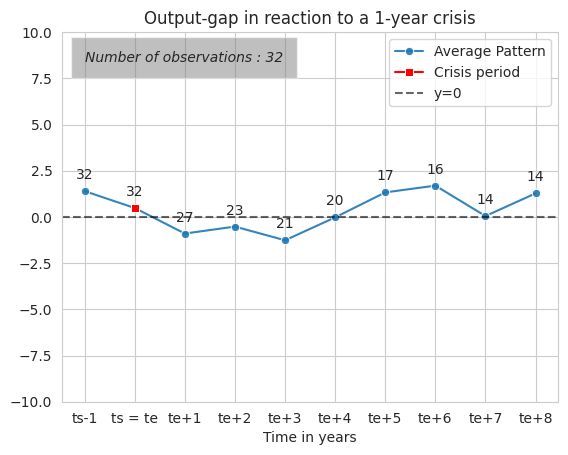

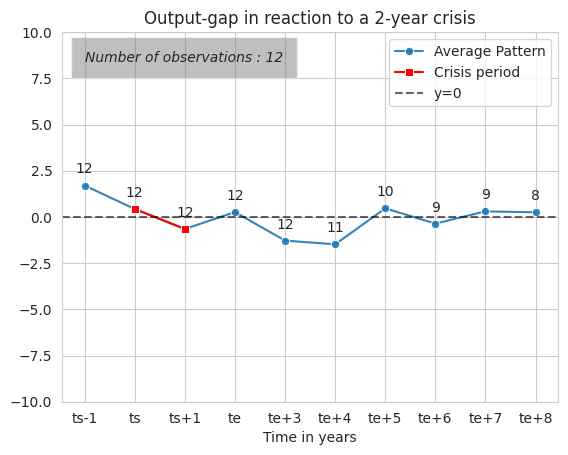

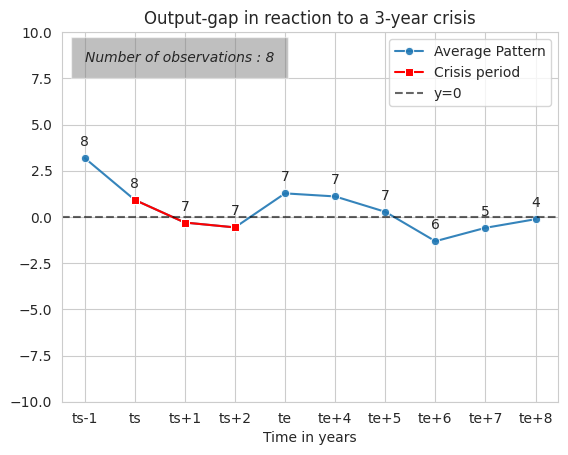

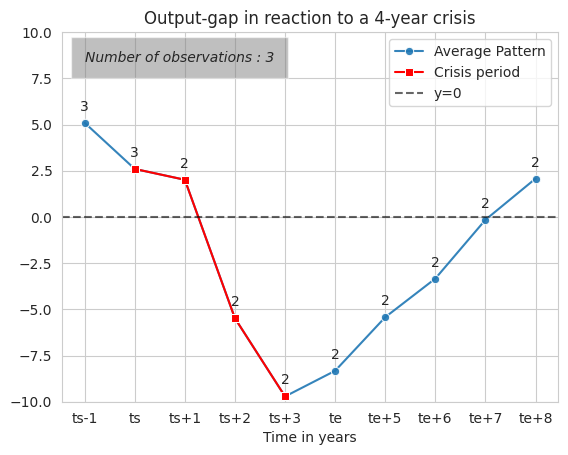

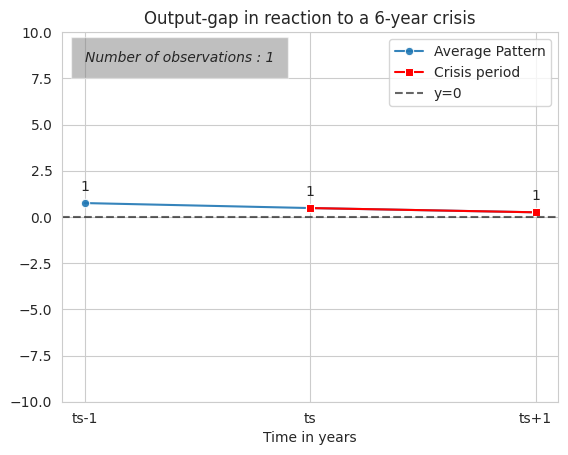

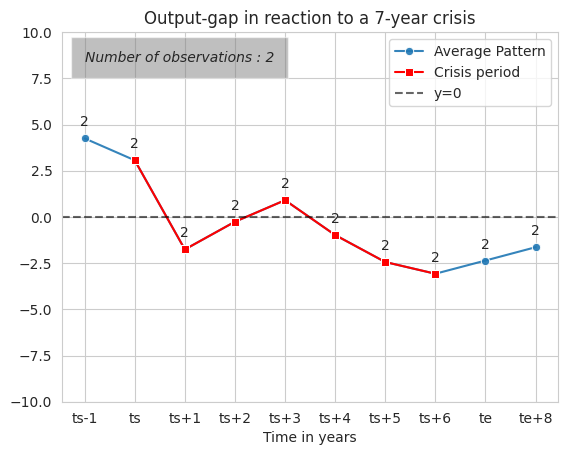

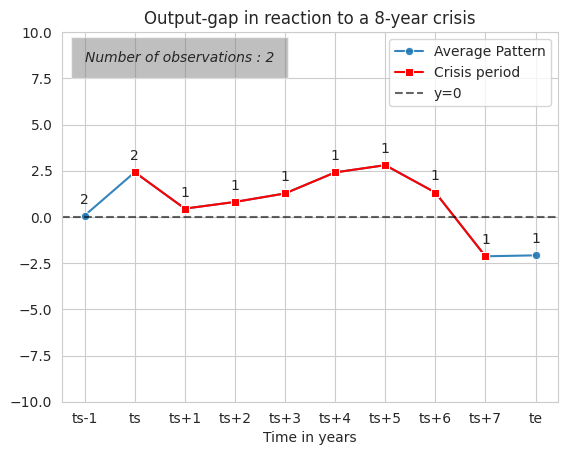

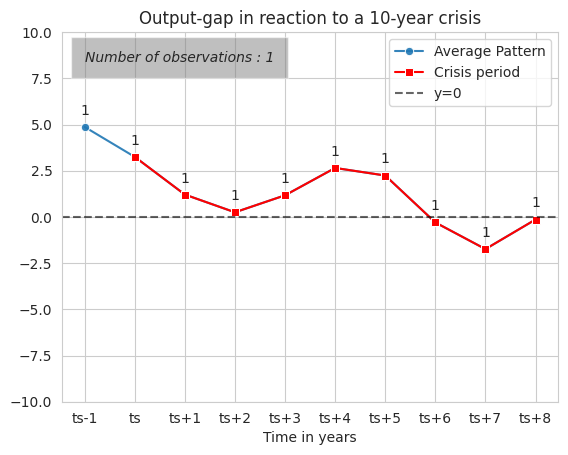

In [22]:
plot_by_crisis_length(output_gap_series, crisis_duration, len_freq, 'Output-gap')

# 4. Crisis & recovery Dynamics in a multiple country database

In [23]:
from functionsA import inflation_dynamics
from functionsA import output_gap_dynamics

In [24]:
from visualisation import plot_dynamics

In [25]:
global_data[(global_data['CC3']=='USA') & (global_data['Year']>1813)]

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
1316,66.0,USA,United States,1814,1.0,State banks suspended specie payments due to W...,1.0,0,4.484304933,NaN,...,1,9.9,1,1,0.0,2.41,0,1,0,0
1317,66.0,USA,United States,1815,0.0,State banks suspended specie payments due to W...,1.0,0,4.750593824,NaN,...,0,-12.3,1,0,0.0,1.88,0,0,0,1
1318,66.0,USA,United States,1816,0.0,State banks suspended specie payments due to W...,1.0,0,4.572473708,NaN,...,0,-8.6,1,0,0.0,-2.33,0,0,0,1
1319,66.0,USA,United States,1817,1.0,Forty-six banks rendered insolvent due to dema...,1.0,0,4.528985507,NaN,...,0,-5.3,1,0,0.0,-2.56,1,0,1,0
1320,66.0,USA,United States,1818,1.0,Forty-six banks rendered insolvent due to dema...,1.0,0,4.340277778,NaN,...,0,-4.4,1,0,0.0,-2.52,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,2.1,1,0,0.0,-1.90,0,0,0,1
1515,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,1.5,1,0,0.0,-1.85,0,0,0,1
1516,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,1.6,1,0,0.0,-1.19,0,0,0,1
1517,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.1,1,0,NaN,-0.32,0,0,0,1


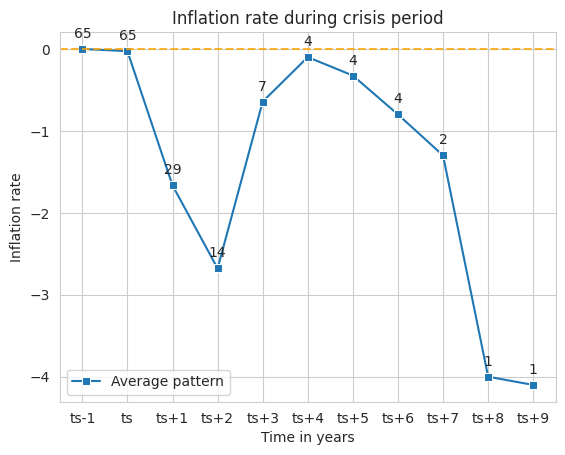

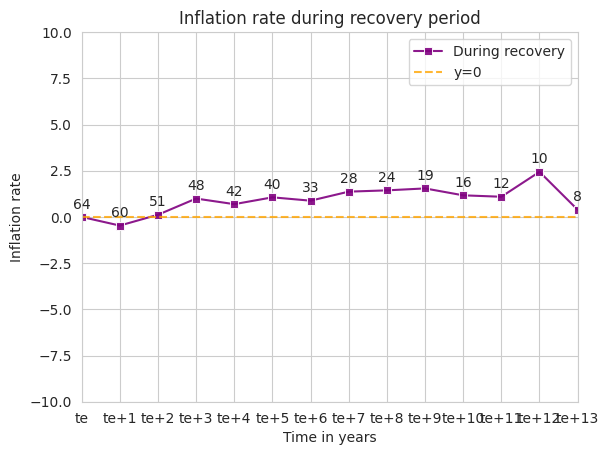

In [26]:
inflation_crisis_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = True))
inflation_recovery_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = False))
plot_dynamics(inflation_crisis_series, inflation_recovery_series, 'Inflation rate')

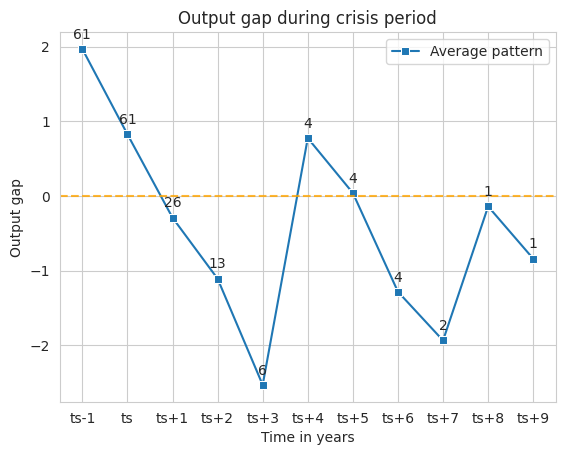

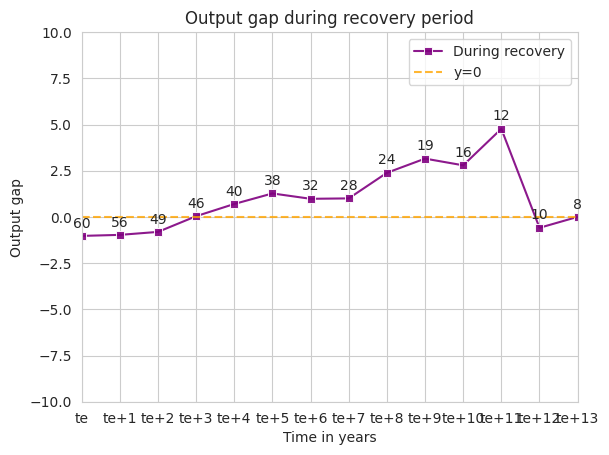

In [27]:
output_gap_crisis_series = output_gap_dynamics(global_data_inner, during_crisis = True)
output_gap_recovery_series = output_gap_dynamics(global_data_inner, during_crisis = False)
plot_dynamics(output_gap_crisis_series, output_gap_recovery_series, 'Output gap')